# data load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

pd.set_option('display.max_columns', 35)  ## 생략 없이 한 번에 띄울 피쳐수 = 35
df0 = pd.read_parquet( "../data/df0.parquet" )
df1 = pd.read_parquet( "../data/df1.parquet" )  ### 추가 피쳐: 페이백율, 할인률, 종합혜택률, 구매시각추출, 구매건카운트
df2 = pd.read_parquet( "../data/df2.parquet" )
df3 = pd.read_parquet( "../data/df3.parquet" )  ### 추가 피쳐: 가입시각추출, 상업코드

print(df0.shape, df1.shape, df2.shape, df3.shape, sep=" "*5)
# display(df0.head(2))
# display(df1.head(2))
# display(df2.head(2))
# display(df3.head(2))

(5623810, 14)     (5623810, 23)     (544921, 17)     (544921, 31)


In [2]:
## 지수 표기법 변경
np.set_printoptions(precision=6, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

## 목표
- 소비 패턴 및 금액에 따라 유저군 분류
- 2020년 4월 마케팅 전략을 수립할 수  있도록 분류된 유저군에 대한 분석

## 점수 산정 방식
- 여러가지 기준으로 feature를 선정
- 각각의 feature를 분포에 따라 여러 그룹으로 나누고, 해당 그룹 유저들의 **총 구매 금액의 평균 금액**의 차등에 따라 점수 부여
- feature 자체의 중요도에 따라 가중치 부여하고, 최종적인 점수를 통해 유저군 분류
  
- 주의점
  - 한 유저 당 평균적인 구매 금액은 약 20만원
  - 하지만 10만원 이하 결제한 고객이 전체 고객의 60%고, 이들이 전체 매출에서 차지하는 비율은 약 10.6%
  - 그룹을 나누는 기준은 절대적인 수치가 아닌 분포 (25%, 50%, 75% 지점)
  - 그렇게 분포로 나눠진 그룹 별 평균 금액의 차등을 기준으로 점수 부여
  - 현재 그룹은 각각 2,4,8개로 나눠져 있으므로, 최대 점수를 4점으로 설정하고 차등에 따라 분배

# Segmentation을 위한 feature 생성

## 구매 등급
- 월별 구매 횟수 구하기
- 최근에 구매를 많이 한 고객은 다음달에도 구매를 많이 할 확률이 상대적으로 높음
- 구매 시기에 따라 차등을 두어 점수 계산 (3월->2.4점, 8월->0.3점 등)
- 피드백: 어떻게 계산했는지 산출 방식 소개 (점수 얘기는 빼기)

In [3]:
# 월별 가중치
# 8개 그룹이므로 
def month_weight(x):
    if x == 8:
        return 0.5
    elif x == 9:
        return 1
    elif x == 10:
        return 1.5
    elif x == 11:
        return 2
    elif x == 12:
        return 2.5
    elif x == 1:
        return 3
    elif x == 2:
        return 3.5
    else:
        return 4

In [4]:
# 인당 월별 구매 횟수
a = df1.groupby(['id','buy_m']).count().reset_index()[['id','buy_m','cnt_b']]
b = df1.groupby(['buy_m']).count().reset_index()[['buy_m','push']]
aa = a.groupby('buy_m').count().reset_index()
aa = aa.merge(b,on='buy_m')
aa = aa.rename(columns={'push':'cnt'})

# 월 평균 구매 횟수
aa['avg_cnt'] = aa['cnt']/aa['id']
a = a.merge(aa[['buy_m','avg_cnt']],on='buy_m')
a['m_point'] = a['buy_m'].apply(month_weight)

# 평균 구매 횟수를 넘겼으면 점수 부여
a['avg_result'] = 0
a.loc[a['cnt_b']>a['avg_cnt'],'avg_result'] = 1
a['score'] = a['m_point']*a['avg_result']
aaa = a.groupby('id').sum().reset_index()

# score로 합계
df2 = df2.merge(aaa[['id','score']],on='id')

In [5]:
df2['score'].value_counts()

0.000     372357
3.000      19828
0.500      13374
3.500      12785
4.000      10039
2.000       9379
2.500       9164
1.500       8905
7.500       7655
10.500      6368
18.000      5967
6.500       5726
5.500       5479
1.000       5475
4.500       4860
5.000       4793
7.000       3816
6.000       3656
9.000       3486
13.000      2807
8.000       2536
14.000      2472
10.000      2336
15.000      2317
9.500       2156
8.500       2132
11.000      2028
11.500      1686
12.500      1683
16.500      1664
17.500      1662
14.500      1476
13.500      1387
12.000      1382
15.500      1039
16.000       556
17.000       490
Name: score, dtype: int64

## 성별

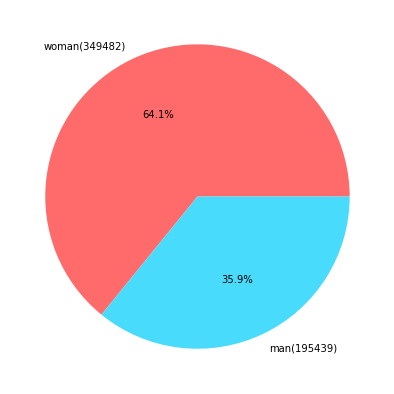

In [6]:
plt.figure(figsize=(7,7),facecolor="white")
man = df2[df2['man'].values==1]['man'].count()
woman = df2[df2['man'].values!=1]['man'].count()
labels = ['woman'+'('+str(woman)+')','man'+'('+str(man)+')']
plt.pie(df2['man'].value_counts(),labels=labels,autopct='%.1f%%',colors=['#ff6b6b','#48dbfb'])
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/2230119164.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/2230119164.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


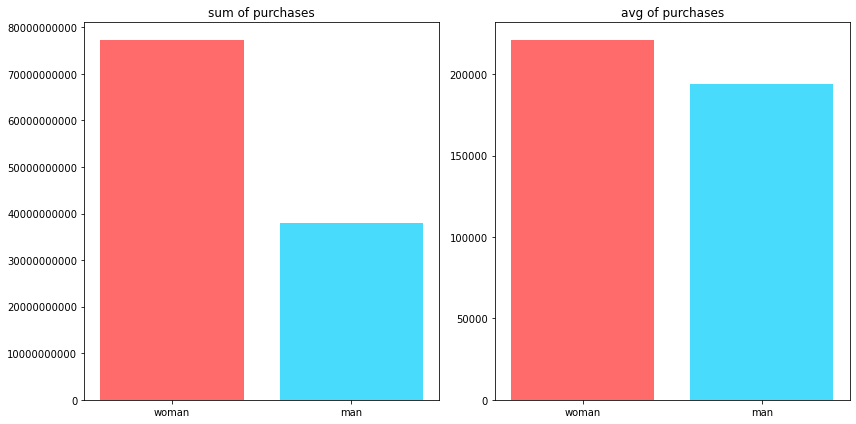

In [7]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
a = df2.groupby('man').sum()['pre'].reset_index()
a.iloc[0,0] = 'woman'
a.iloc[1,0] = 'man'
plt.title('sum of purchases')
plt.bar(a['man'],a['pre'],color=['#ff6b6b','#48dbfb'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
b = df2.groupby('man').mean()['pre'].reset_index()
b.iloc[0,0] = 'woman'
b.iloc[1,0] = 'man'
plt.title('avg of purchases')
plt.bar(b['man'],b['pre'],color=['#ff6b6b','#48dbfb'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

### 결론
- 남성보다 여성이 거래량 자체도 많고, 총액, 평균 금액 등 높으므로 여성에게 높은 점수 부여
- 총점 4점이 되도록 1:3 으로 분배

In [8]:
# 점수 생성
def s_gender(man):
    if man == 1:
        return 1
    else:
        return 3

## push 알림 설정 여부

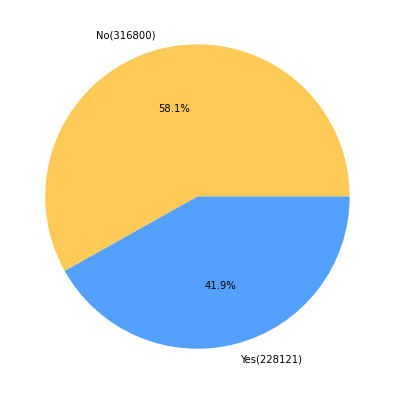

In [9]:
plt.figure(figsize=(7,7),facecolor="white")
yes = df2[df2['push'].values==1]['push'].count()
no = df2[df2['push'].values!=1]['push'].count()
labels = ['No'+'('+str(no)+')','Yes'+'('+str(yes)+')']
plt.pie(df2['push'].value_counts(),labels=labels,autopct='%.1f%%',colors=['#feca57','#54a0ff'])
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/2882050237.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/2882050237.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


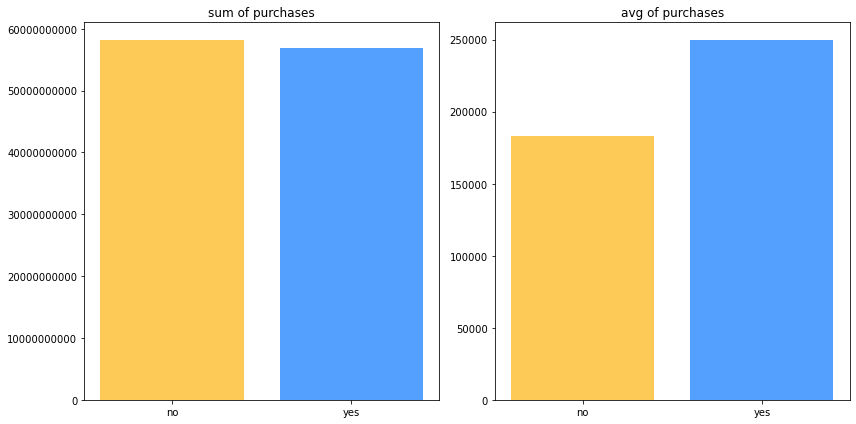

In [10]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
a = df2.groupby('push').sum()['pre'].reset_index()
a.iloc[0,0] = 'no'
a.iloc[1,0] = 'yes'
plt.title('sum of purchases')
plt.bar(a['push'],a['pre'],color=['#feca57','#54a0ff'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
b = df2.groupby('push').mean()['pre'].reset_index()
b.iloc[0,0] = 'no'
b.iloc[1,0] = 'yes'
plt.title('avg of purchases')
plt.bar(b['push'],b['pre'],color=['#feca57','#54a0ff'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

### 결론
- 미설정보다 설정 유저가 숫자는 적지만 총액도 비슷하고, 평균 금액 등이 더 높으므로 설정 유저에게 높은 점수 부여
- 총점 4점이 되도록 1:3 으로 분배

In [11]:
# 점수 생성
def s_push(push):
    if push == 0:
        return 1
    else:
        return 3

## 연령대별

/Users/luci031/miniforge3/envs/yds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

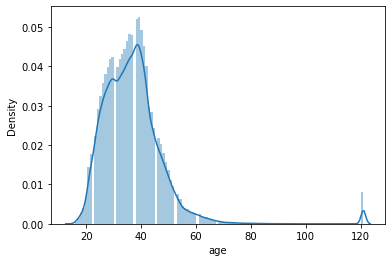

In [12]:
sns.distplot(df2['age'],bins=120)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/1866640328.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/1866640328.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


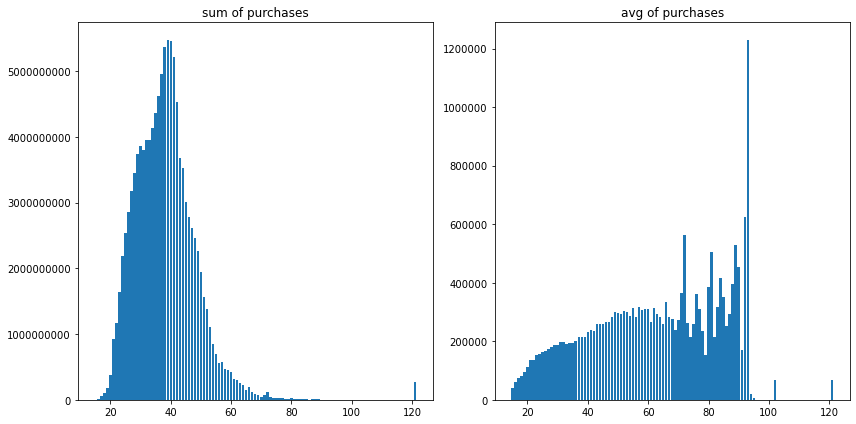

In [13]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('age').sum()['pre'].index,df2.groupby('age').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('age').mean()['pre'].index,df2.groupby('age').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

### 결론
- 결제가 가장 많은 나이대는 30~50세 구간
- 그러나 나이라는 feature 특성 상 이들을 모두 한 구간에 엮기는 어려움
- 소비 패턴 및 분포에 따라 각 구간 설정
  - ~29세: 일부 10대 및 대부분 20대 구간, 인원 자체는 많지만 평균 소비 금액이 가장 적으므로 0.4점
  - 30~39세: 매출의 대부분을 차지하는 구간 1, 그러나 뒤의 40~59세 보다 평균 소비 금액은 적으므로 1.2점
  - 40~59세: 매출의 대부분을 차지하는 구간 2, 소비력도 충분하고 인원도 충분하므로 가장 높은 점수인 1.6점
  - 60세~: 개개인의 매출 자체는 크나 인원도 적고, 편차도 크기 때문에 0.8점

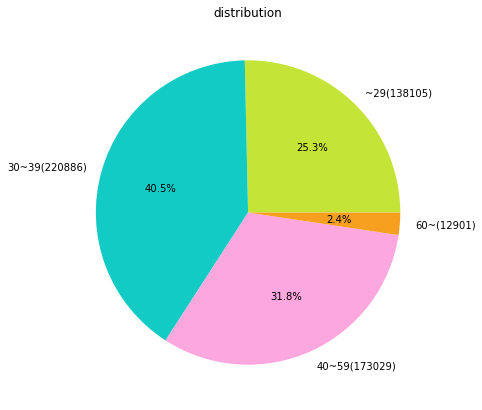

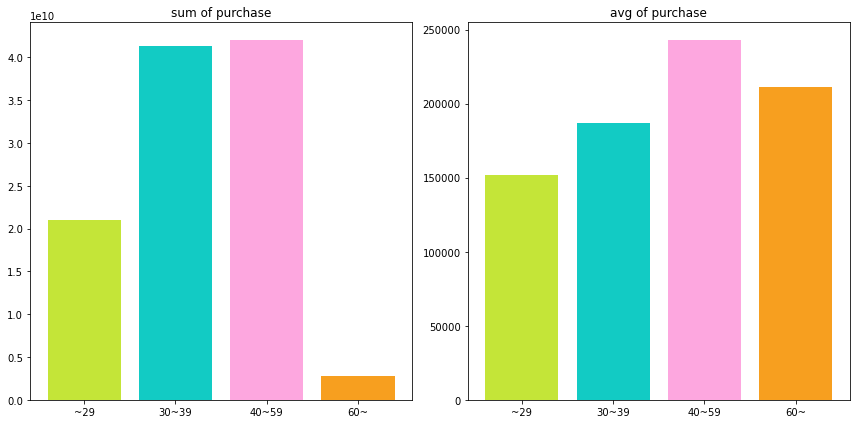

In [14]:
g1 = df2[df2['age']<30]
g2 = df2[(df2['age']>=30) & (df2['age']<40)]
g3 = df2[(df2['age']>=40) & (df2['age']<60)]
g4 = df2[df2['age']>=60]

colors = ['#C4E538','#12CBC4','#FDA7DF','#F79F1F']

plt.figure(figsize=(7,7),facecolor="white")
g1_c = g1['push'].count()
g2_c = g2['push'].count()
g3_c = g3['push'].count()
g4_c = g4['push'].count()
labels = ['~29'+'('+str(g1_c)+')','30~39'+'('+str(g2_c)+')','40~59'+'('+str(g3_c)+')','60~'+'('+str(g4_c)+')']
plt.title('distribution')
plt.pie([g1_c,g2_c,g3_c,g4_c],labels=labels,autopct='%.1f%%',colors=colors)
plt.show()

plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title('sum of purchase')
plt.bar(['~29','30~39','40~59','60~'],[g1['post'].sum(),g2['post'].sum(),g3['post'].sum(),g4['post'].sum()], color=colors)

plt.subplot(1,2,2)
plt.title('avg of purchase')
plt.bar(['~29','30~39','40~59','60~'],[g1['post'].mean(),g2['post'].mean(),g3['post'].mean(),g4['post'].mean()], color=colors)

plt.tight_layout()
plt.show()

In [15]:
# 점수 생성
def s_age(age):
    if age < 30:
        return 0.4
    elif 30 <= age < 40:
        return 1.2
    elif 40 <= age < 60:
        return 1.6
    else:
        return 0.8

## 구매 횟수별 (once and more)

- 피드백: 분포 리미트 확인해서 좀 더 보기 좋게 만들기, 똑같이 20만원 썼을 때 3 4번 결제한 사람이 수수료 더 내기 때문에 개꿀

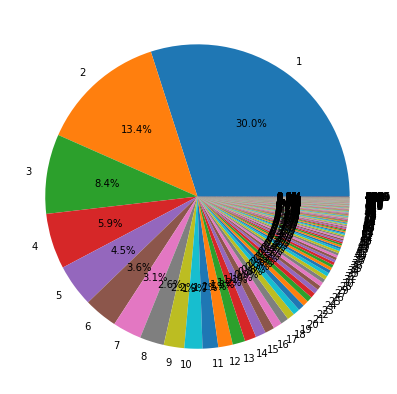

In [16]:
plt.figure(figsize=(7,7),facecolor="white")
labels = df2['cnt_b'].value_counts().index.to_list()
plt.pie(df2['cnt_b'].value_counts(),labels=labels,autopct='%.1f%%')
plt.show()

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/1445558188.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/1445558188.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


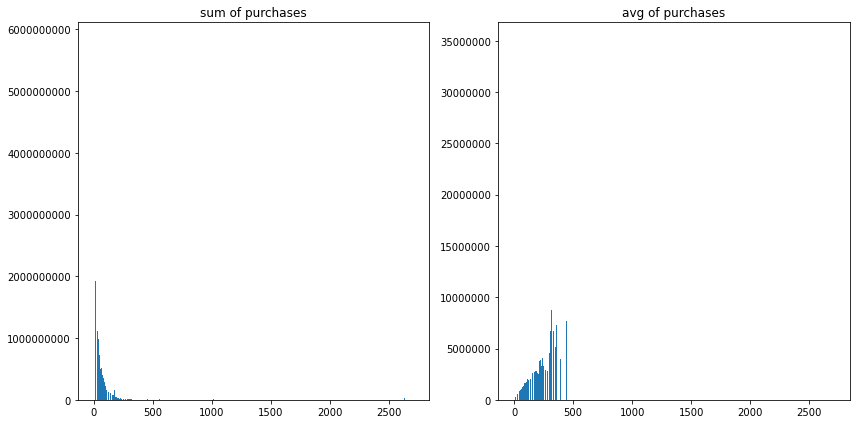

In [17]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('cnt_b').sum()['pre'].index,df2.groupby('cnt_b').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('cnt_b').mean()['pre'].index,df2.groupby('cnt_b').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

### 결론
- 구매 횟수가 많을수록 소비한 금액이 많음
- 데이터의 분포에 따라 최대한 일정한 비율로 나뉘도록 분류
- 비율에 따라 구간 설정
- 많이 결제했을수록 높은 점수 부여

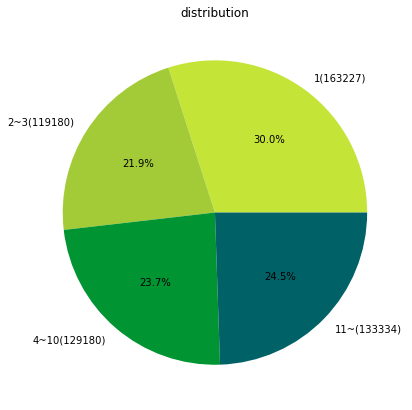

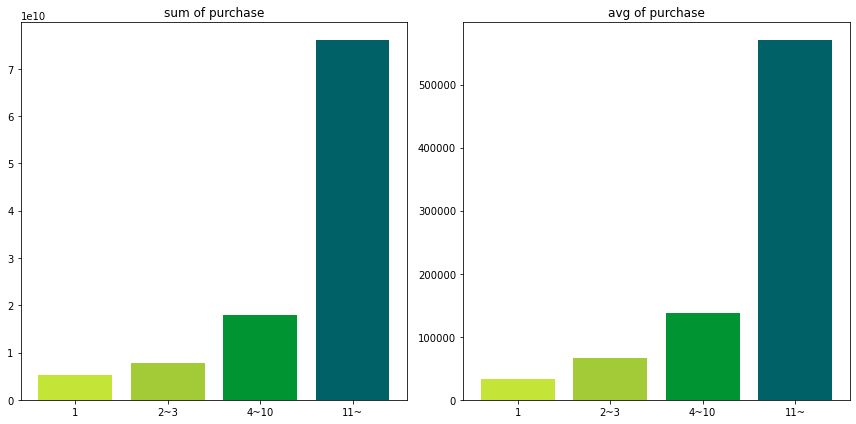

In [18]:
g1 = df2[df2['cnt_b']<2]
g2 = df2[(df2['cnt_b']>=2) & (df2['cnt_b']<4)]
g3 = df2[(df2['cnt_b']>=4) & (df2['cnt_b']<11)]
g4 = df2[df2['cnt_b']>=11]
names = ['1','2~3','4~10','11~']

colors = ['#C4E538','#A3CB38','#009432','#006266']

plt.figure(figsize=(7,7),facecolor="white")
g1_c = g1['push'].count()
g2_c = g2['push'].count()
g3_c = g3['push'].count()
g4_c = g4['push'].count()
labels = [names[0]+'('+str(g1_c)+')',names[1]+'('+str(g2_c)+')',names[2]+'('+str(g3_c)+')',names[3]+'('+str(g4_c)+')']
plt.title('distribution')
plt.pie([g1_c,g2_c,g3_c,g4_c],labels=labels,autopct='%.1f%%',colors=colors)
plt.show()

plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title('sum of purchase')
plt.bar(names,[g1['post'].sum(),g2['post'].sum(),g3['post'].sum(),g4['post'].sum()], color=colors)

plt.subplot(1,2,2)
plt.title('avg of purchase')
plt.bar(names,[g1['post'].mean(),g2['post'].mean(),g3['post'].mean(),g4['post'].mean()], color=colors)

plt.tight_layout()
plt.show()

In [19]:
# 점수 생성
def s_cnt_b(cnt_b):
    if cnt_b < 2:
        return 0.4
    elif 2 <= cnt_b < 4:
        return 0.8
    elif 4 <= cnt_b < 11:
        return 1.2
    else:
        return 1.6

## 할인율

- 유저 별 구매 당 평균적인 할인 비율
- 평균적으로 낮은 할인율로 구매하는 고객에게 더 점수를 부여

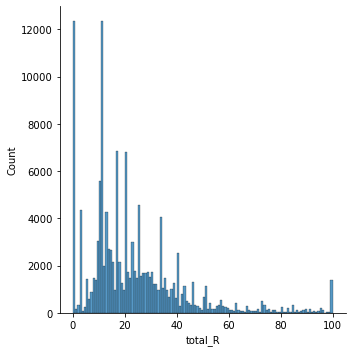

In [20]:

sns.displot(df2[df2['post']<20000]['total_R'],bins=120)

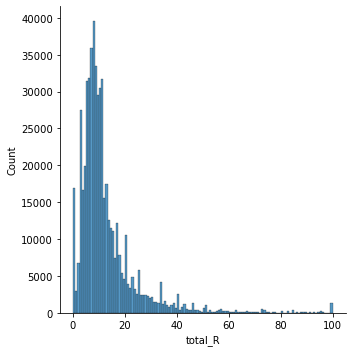

In [21]:
sns.displot(df2['total_R'],bins=120)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/671264884.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_1829/671264884.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


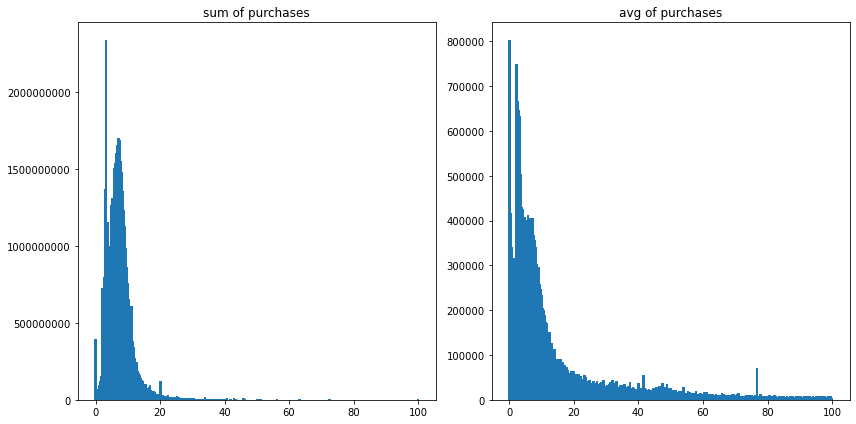

In [22]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df2.groupby('total_R').sum()['pre'].index,df2.groupby('total_R').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df2.groupby('total_R').mean()['pre'].index,df2.groupby('total_R').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [23]:
df2['total_R'].value_counts()

0.000     15865
11.100    13200
3.000     11493
3.200      7497
10.100     5705
          ...  
96.100        1
92.300        1
98.100        1
90.300        1
99.400        1
Name: total_R, Length: 951, dtype: int64

### 결론
- 평균적으로 낮은 할인율로 구매한 고객이 매출에 도움이 됨
- 데이터의 분포에 따라 최대한 일정한 비율로 나뉘도록 분류
- 비율에 따라 구간 설정
- 할인율이 낮을수록 높은 점수 부여

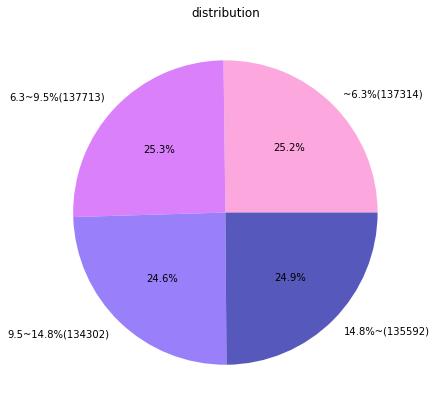

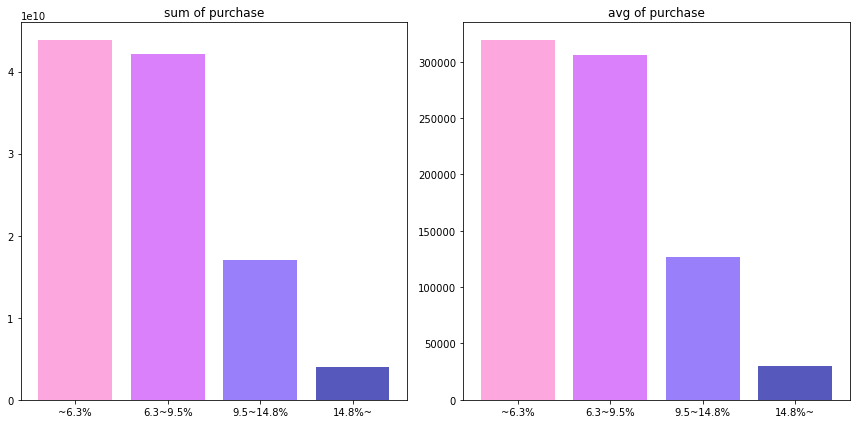

In [24]:
g1 = df2[df2['total_R']<6.3]
g2 = df2[(df2['total_R']>=6.3) & (df2['total_R']<9.5)]
g3 = df2[(df2['total_R']>=9.5) & (df2['total_R']<14.8)]
g4 = df2[df2['total_R']>=14.8]
names = ['~6.3%','6.3~9.5%','9.5~14.8%','14.8%~']

colors = ['#FDA7DF','#D980FA','#9980FA','#5758BB']

plt.figure(figsize=(7,7),facecolor="white")
g1_c = g1['push'].count()
g2_c = g2['push'].count()
g3_c = g3['push'].count()
g4_c = g4['push'].count()
labels = [names[0]+'('+str(g1_c)+')',names[1]+'('+str(g2_c)+')',names[2]+'('+str(g3_c)+')',names[3]+'('+str(g4_c)+')']
plt.title('distribution')
plt.pie([g1_c,g2_c,g3_c,g4_c],labels=labels,autopct='%.1f%%',colors=colors)
plt.show()

plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title('sum of purchase')
plt.bar(names,[g1['post'].sum(),g2['post'].sum(),g3['post'].sum(),g4['post'].sum()], color=colors)

plt.subplot(1,2,2)
plt.title('avg of purchase')
plt.bar(names,[g1['post'].mean(),g2['post'].mean(),g3['post'].mean(),g4['post'].mean()], color=colors)

plt.tight_layout()
plt.show()

In [25]:
# 점수 생성
def s_total_R(total_R):
    if total_R < 6.3:
        return 1.6
    elif 6.3 <= total_R < 9.5:
        return 1.2
    elif 9.5 <= total_R < 14.8:
        return 0.8
    else:
        return 0.4

## 점수 종합

- 피드백: 피쳐 별 중요도에 따라 가중치
- 가중치 시스템 설명 잘하기
- 피쳐별 점수 1,2점 주고 

In [26]:
df2['score'] += df2['age'].apply(s_age)
df2['score'] += df2['man'].apply(s_gender)
df2['score'] += df2['push'].apply(s_push)
df2['score'] += df2['cnt_b'].apply(s_cnt_b)
df2['score'] += df2['total_R'].apply(s_total_R)
df2

,id,age,man,push,frgn,birth,sign,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,24330,18960,0,5370,5370,0.000,22.100,22.100,1,2,6.400
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,25030,19359,0,5671,5671,0.000,22.700,22.700,1,2,5.600
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,18120,13440,0,4680,4680,0.000,25.800,25.800,1,1,6.400
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,227640,216980,0,10660,10660,0.000,4.700,4.700,1,8,8.000
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,65170,55170,0,10000,10000,0.000,15.300,15.300,1,6,9.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544916,544917,27,0,0,0,1994-07-08,2019-08-11 01:56:44.713,41220,34740,0,6480,6480,0.000,15.700,15.700,1,2,5.600
544917,544918,23,0,1,0,1998-02-26,2019-12-08 12:28:08.093,268665,252665,2296,16000,18296,0.900,6.000,6.800,1,21,16.200
544918,544919,41,0,1,0,1980-03-25,2019-08-03 16:06:57.300,529022,483123,177,45899,46076,0.000,8.700,8.700,1,43,17.900
544919,544920,49,1,1,0,1972-02-07,2019-08-31 11:02:08.238,462100,429100,441,33000,33441,0.100,7.100,7.200,1,7,8.000


/Users/luci031/miniforge3/envs/yds/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='score', ylabel='Density'>

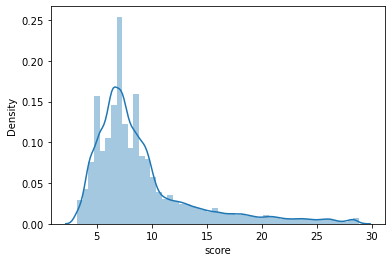

In [27]:
sns.distplot(df2['score'])

In [28]:
df2['score'].describe()

count   544921.000
mean         9.106
std          4.780
min          3.200
25%          6.000
50%          7.600
75%         10.000
max         28.800
Name: score, dtype: float64

In [29]:
# 파일 생성하며 마무리
df2.to_parquet( "df2_score.parquet", engine="pyarrow", compression='gzip' )

# etc

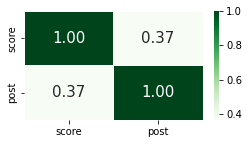

In [39]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(4, 2))
sns.heatmap(df2[["score","post"]].corr(), cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

In [40]:
df2.corr()

,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
id,1.000,-0.001,-0.001,-0.001,-0.000,0.000,0.000,0.000,-0.001,-0.001,0.000,-0.000,-0.000,NaN,-0.000,-0.001
age,-0.001,1.000,0.064,0.129,-0.014,0.047,0.045,0.024,0.076,0.073,-0.052,0.090,0.087,NaN,0.065,0.161
man,-0.001,0.064,1.000,-0.072,-0.023,-0.024,-0.023,-0.031,-0.042,-0.043,-0.009,0.069,0.070,NaN,-0.085,-0.343
push,-0.001,0.129,-0.072,1.000,0.047,0.059,0.058,0.064,0.074,0.078,0.034,-0.059,-0.057,NaN,0.099,0.620
frgn,-0.000,-0.014,-0.023,0.047,1.000,0.025,0.025,0.034,0.018,0.023,0.015,-0.018,-0.017,NaN,0.034,0.047
pre,0.000,0.047,-0.024,0.059,0.025,1.000,1.000,0.474,0.846,0.855,0.065,-0.165,-0.162,NaN,0.626,0.376
post,0.000,0.045,-0.023,0.058,0.025,1.000,1.000,0.473,0.831,0.841,0.068,-0.167,-0.164,NaN,0.612,0.366
c_back,0.000,0.024,-0.031,0.064,0.034,0.474,0.473,1.000,0.427,0.558,0.400,-0.150,-0.123,NaN,0.588,0.331
dscnt,-0.001,0.076,-0.042,0.074,0.018,0.846,0.831,0.427,1.000,0.989,0.004,-0.098,-0.099,NaN,0.809,0.515
total,-0.001,0.073,-0.043,0.078,0.023,0.855,0.841,0.558,0.989,1.000,0.070,-0.115,-0.112,NaN,0.841,0.528


In [41]:
df2[df2['score']<51.3].count()/df2['score'].count()

id         0.950
age        0.950
man        0.950
push       0.950
frgn       0.950
birth      0.950
sign       0.950
pre        0.950
post       0.950
c_back     0.950
dscnt      0.950
total      0.950
c_back_R   0.950
dscnt_R    0.950
total_R    0.950
cnt_p      0.950
cnt_b      0.950
score      0.950
dtype: float64

In [42]:
#하위 80% 상위 15% 최상위 5%로 분리
print('~80%')
a = df2[df2['score']<41.6].describe()
display(a)
print('80~95%')
b = df2[(df2['score']>=41.6) & (df2['score']<51.3)].describe()
display(b)
print('95~%')
c = df2[df2['score']>=51.3].describe()
display(c)

~80%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000,438709.000
mean,272523.590,36.132,0.406,0.320,0.004,117228.285,108701.604,513.629,8526.681,9040.310,0.388,13.330,13.718,1.000,4.831,29.593
std,157362.246,11.843,0.491,0.466,0.065,338287.781,326277.759,2206.008,14449.224,14978.918,0.892,13.527,13.339,0.000,7.369,6.712
min,1.000,15.000,0.000,0.000,0.000,500.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,14.500
25%,136233.000,29.000,0.000,0.000,0.000,19200.000,16000.000,0.000,2000.000,2000.000,0.000,5.600,6.200,1.000,1.000,23.500
50%,272508.000,35.000,0.000,0.000,0.000,45500.000,40392.000,0.000,5000.000,5000.000,0.000,9.900,10.100,1.000,2.000,29.500
75%,408899.000,41.000,1.000,1.000,0.000,115806.000,106510.000,192.000,9700.000,10000.000,0.200,16.500,16.800,1.000,5.000,35.400
max,544921.000,121.000,1.000,1.000,1.000,66233030.000,64744230.000,202326.000,1488800.000,1488800.000,5.000,100.000,100.000,1.000,477.000,41.500


80~95%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000,78888.000
mean,271888.107,38.951,0.194,0.768,0.011,470298.099,438562.741,3138.148,31735.359,34873.506,0.647,8.246,8.893,1.000,24.494,45.744
std,157192.242,10.052,0.395,0.422,0.103,912206.691,882048.907,6955.859,37314.205,40042.255,0.899,4.492,4.228,0.000,25.566,2.769
min,5.000,15.000,0.000,0.000,0.000,10000.000,7200.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,41.600
25%,135873.500,32.000,0.000,1.000,0.000,155388.750,141157.250,0.000,12000.000,13563.000,0.000,5.500,6.300,1.000,10.000,43.400
50%,271668.000,39.000,0.000,1.000,0.000,288081.500,266065.000,894.000,21362.000,23365.000,0.300,7.600,8.200,1.000,16.000,45.300
75%,407674.750,45.000,0.000,1.000,0.000,550761.500,512551.500,3342.000,38878.750,42203.250,0.900,10.100,10.400,1.000,30.000,48.000
max,544918.000,121.000,1.000,1.000,1.000,115005350.000,112273800.000,196824.000,2731550.000,2731550.000,5.000,52.600,53.300,1.000,426.000,51.200


95~%


,id,age,man,push,frgn,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
count,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000,27324.000
mean,273110.080,42.001,0.080,1.000,0.015,970096.286,906075.712,7940.652,64020.574,71961.226,0.806,7.230,8.037,1.000,57.533,54.657
std,156716.947,9.146,0.271,0.000,0.123,938877.141,896920.923,13215.207,51744.948,58071.227,0.810,2.930,2.717,0.000,50.692,2.417
min,53.000,16.000,0.000,1.000,0.000,88367.000,80000.000,0.000,0.000,3537.000,0.000,0.000,1.400,1.000,11.000,51.300
25%,137221.250,37.000,0.000,1.000,0.000,452416.250,417750.250,1497.000,31870.000,36237.750,0.200,5.300,6.300,1.000,30.000,52.600
50%,273878.000,42.000,0.000,1.000,0.000,723600.000,670596.000,4249.500,50572.500,56243.500,0.600,6.900,7.600,1.000,45.000,54.300
75%,408274.500,48.000,0.000,1.000,0.000,1192126.500,1111263.500,9420.250,80177.250,88665.250,1.100,8.800,9.400,1.000,70.000,56.400
max,544919.000,121.000,1.000,1.000,1.000,35043786.000,34447704.000,851803.000,1150002.000,1330657.000,5.000,33.000,36.000,1.000,2705.000,61.300


## 시간대별

### 날짜별

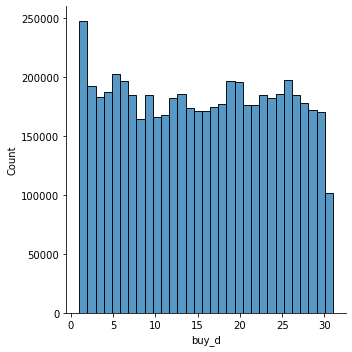

In [ ]:
sns.displot(df1['buy_d'],bins=31)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2576/3751378546.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2576/3751378546.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


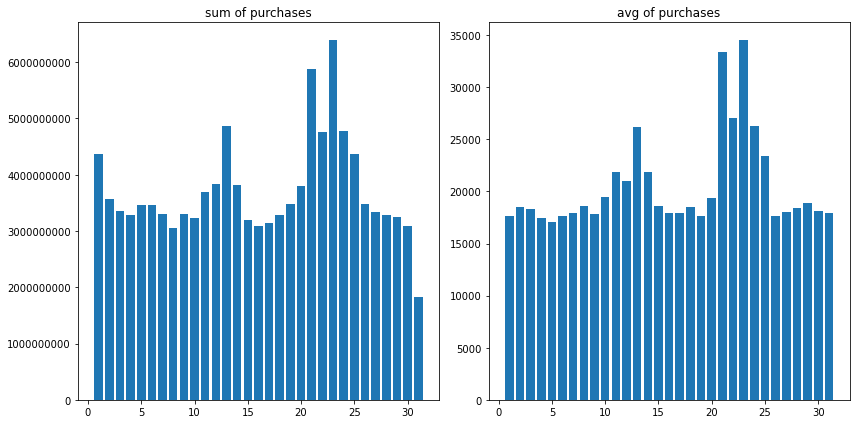

In [ ]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df1.groupby('buy_d').sum()['pre'].index,df1.groupby('buy_d').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df1.groupby('buy_d').mean()['pre'].index,df1.groupby('buy_d').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

In [ ]:
# 인당 평균 구매일
a = df1.groupby('id').mean().reset_index()[['id','buy_d']]
def truncs(num):
    return int(num//1)
a['buy_d'] = a['buy_d'].apply(truncs)
a['buy_d'] = a['buy_d'].astype(int)
df3 = df3.merge(a,on='id')

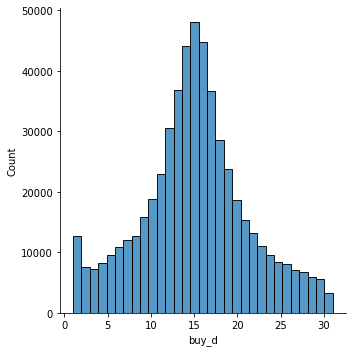

In [ ]:
sns.displot(df3['buy_d'],bins=31)

/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2576/810107199.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
/var/folders/nq/s4zx76p53d11lnr0t1dxpxh00000gn/T/ipykernel_2576/810107199.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])


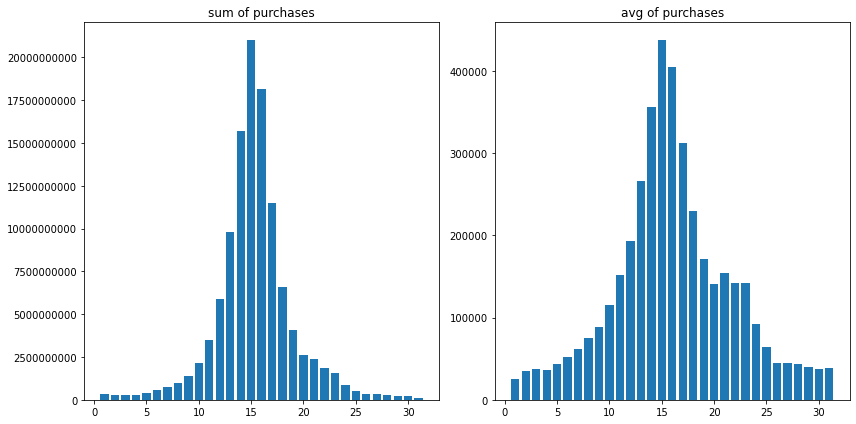

In [ ]:
plt.figure(figsize=(12,6),facecolor="white")
plt.subplot(1,2,1)
plt.title("sum of purchases")
plt.bar(df3.groupby('buy_d').sum()['pre'].index,df3.groupby('buy_d').sum()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.subplot(1,2,2)
plt.title("avg of purchases")
plt.bar(df3.groupby('buy_d').mean()['pre'].index,df3.groupby('buy_d').mean()['pre'])
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.tight_layout()
plt.show()

## 외국인별, merchant_id 별

##